## Stock close price prediction

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


### Get Stock Price History Data from yahoo finance

In [2]:
def get_stock_data(filename, normalized=0):
    #url = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2012&d=29&e=10&f=2017&g=d&ignore=.csv' % stock_name
    
    col_names = ['Date','Open','High','Low','Close','Volume']
    stocks = pd.read_csv(filename, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    date_split = df['Date'].str.split('-').str
    df['Year'], df['Month'], df['Day'] = date_split
    #df["Volume"] = pd.to_numeric(df["Volume"].astype(int), errors='coerce')
    df.drop(df.columns[[0,1,2,3,5,6,7,8]], axis=1, inplace=True) 
    return df

In [3]:
filename = '2618.TW_2.csv'
df = get_stock_data(filename,0)
df.head()

,Close
0,15.00
1,15.15
2,14.60
3,14.45
4,14.55


In [4]:
df.dtypes

Close    float64
dtype: object

### Load data into time series format

In [5]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    
    #if normalise_window:
    #    result = normalise_windows(result)
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1] # The close price
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] # The close price

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [6]:
seq_len = 50
X_train, y_train, X_test, y_test = load_data(df[::-1], seq_len)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (935, 50, 1)
y_train (935,)
X_test (234, 50, 1)
y_test (234,)


In [7]:
X_train

array([[[ 18.5 ],
        [ 18.35],
        [ 18.65],
        ..., 
        [ 17.05],
        [ 16.8 ],
        [ 16.8 ]],

       [[ 18.35],
        [ 18.65],
        [ 18.  ],
        ..., 
        [ 16.8 ],
        [ 16.8 ],
        [ 16.6 ]],

       [[ 18.65],
        [ 18.  ],
        [ 18.15],
        ..., 
        [ 16.8 ],
        [ 16.6 ],
        [ 16.5 ]],

       ..., 
       [[ 17.05],
        [ 16.95],
        [ 16.9 ],
        ..., 
        [ 14.9 ],
        [ 14.95],
        [ 14.9 ]],

       [[ 16.95],
        [ 16.9 ],
        [ 16.6 ],
        ..., 
        [ 14.95],
        [ 14.9 ],
        [ 14.85]],

       [[ 16.9 ],
        [ 16.6 ],
        [ 16.25],
        ..., 
        [ 14.9 ],
        [ 14.85],
        [ 14.7 ]]])

### Define RNN model

In [8]:
def build_model(layers): 
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True)) #return_sequence?
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    
    #model.compile
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model


### Build model

In [9]:
# model = build_model([3,lag,1])
model = build_model([1,50,100,1])

/Users/hsiangweiliang/anaconda/lib/python3.5/site-packages/keras/legacy/interfaces.py:169: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  warnings.warn('The `input_dim` and `input_length` arguments '
/Users/hsiangweiliang/anaconda/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, input_shape=(None, 1), return_sequences=True)`
  '` call to the Keras 2 API: ' + signature)


> Compilation Time :  0.030996084213256836


/Users/hsiangweiliang/anaconda/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  '` call to the Keras 2 API: ' + signature)


### Train model

In [10]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=10,
    validation_split=0.1,
    verbose=1)

Train on 841 samples, validate on 94 samples
Epoch 1/10
841/841 [==============================] - 4s - loss: 302.5554 - val_loss: 172.8377
Epoch 2/10
841/841 [==============================] - 2s - loss: 212.7341 - val_loss: 104.6397
Epoch 3/10
841/841 [==============================] - 3s - loss: 140.8920 - val_loss: 68.8155
Epoch 4/10
841/841 [==============================] - 3s - loss: 100.4890 - val_loss: 44.5169
Epoch 5/10
841/841 [==============================] - 2s - loss: 72.7584 - val_loss: 27.4288
Epoch 6/10
841/841 [==============================] - 2s - loss: 52.0318 - val_loss: 17.5848
Epoch 7/10
841/841 [==============================] - 3s - loss: 39.7367 - val_loss: 12.5045
Epoch 8/10
841/841 [==============================] - 2s - loss: 31.9030 - val_loss: 9.6879
Epoch 9/10
841/841 [==============================] - 3s - loss: 27.9036 - val_loss: 7.9358
Epoch 10/10
841/841 [==============================] - 2s - loss: 24.7166 - val_loss: 6.7698


### Evaluate model

In [11]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

IndexError: invalid index to scalar variable.

### Make Prediction

In [12]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

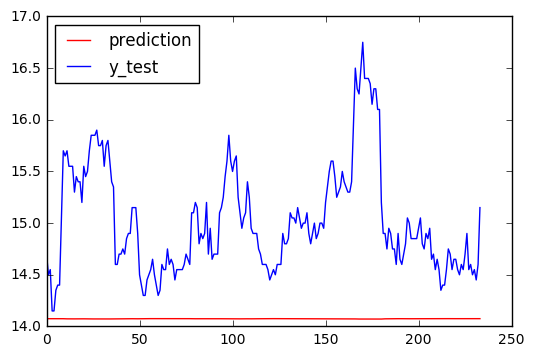

In [13]:
import matplotlib.pyplot as plt2
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [14]:
from numpy import newaxis
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.legend(loc='upper left')
    plt.show()

In [17]:
prediction2 = predict_sequences_multiple(model, X_test, 50, 60)

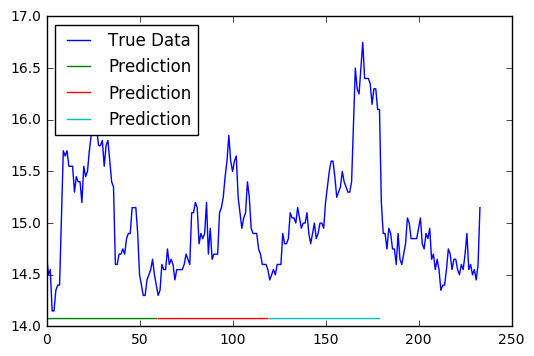

In [18]:
plot_results_multiple(prediction2, y_test, 60)